<img align="right" src="https://druggablegenome.net/IDG_Images_Index/IDGLOGO.png" width="400">
# TIN-X API Introduction
### TIN-X REST API examples.
  * http://api.newdrugtargets.org/
  * http://api.newdrugtargets.org/docs/
  * http://newdrugtargets.org/
 
<a href="https://academic.oup.com/bioinformatics/article/3111842/TIN-X-Target-Importance-and-Novelty-Explorer" target="_blank">TIN-X: Target Importance and Novelty Explorer</a>, DC Cannon, JJ Yang, SL Mathias, O Ursu, S Mani, A Waller, SC Schürer, LJ Jensen, LA Sklar, CG Bologa, TI Oprea, Bioinformatics, 2017, btx200, doi: 10.1093/bioinformatics/btx200.

### Imports

In [1]:
import sys,os
import scipy,numpy
import pandas
import matplotlib,matplotlib.pyplot
import altair #Ok for Colaboratory, not GitHub
print('Python: %s; Pandas: %s; Scipy: %s ; Numpy: %s; Matplotlib: %s; Altair: %s'%(sys.version.split()[0],pandas.__version__,scipy.__version__,numpy.__version__,matplotlib.__version__, altair.__version__))

Python: 3.6.7; Pandas: 0.22.0; Scipy: 1.1.0 ; Numpy: 1.14.6; Matplotlib: 2.1.2; Altair: 2.2.2


### Install coreapi

In [2]:
!pip install coreapi
import coreapi
print('Coreapi: %s'%(coreapi.__version__))

  Running setup.py bdist_wheel for itypes ... - done
  Stored in directory: /root/.cache/pip/wheels/7b/52/af/4e27324812e7ab7bbbc30f748d317f3739477562325cb4c723
  Running setup.py bdist_wheel for coreschema ... - done
  Stored in directory: /root/.cache/pip/wheels/10/7b/ba/04fcd6b33e6123ca11a5f5ab56decb1a2d87ced028377a1377
Successfully built itypes coreschema
Coreapi: 2.3.3


### Instantiate Coreapi client. Fetch TIN-X API schema.

In [0]:
client = coreapi.Client()
schema = client.get("http://api.newdrugtargets.org/docs/")

### Search for "Gout", rank by name length.

In [4]:
action = ["diseases", "list"]
params = { "search": "Gout", "limit": 10, "offset": 0 }
response = client.action(schema, action, params=params)
diseases = pandas.DataFrame(response['results'])
diseases[['id', 'doid', 'name', 'summary']]
diseases.reindex(diseases.name.str.len().sort_values().index)

,id,doid,name,category,summary,num_important_targets,novelty,targets,children,parent
0,62,DOID:13189,gout,disease of anatomical entity,An arthritis that has_material_basis_in uric a...,885,0.0009847300000000,http://api.newdrugtargets.org/diseases/62/targ...,http://api.newdrugtargets.org/diseases/62/chil...,http://api.newdrugtargets.org/diseases/62/parent/


### Fetch targets for top hit disease ID.

In [0]:
disease_id = int(diseases.id[0])
disease_name = diseases.name[0]
action = ["diseases", "targets", "list"]
params = { "disease_id":disease_id, "limit":1000, "offset":0 }
response = client.action(schema, action, params=params)

In [6]:
tinx = pandas.DataFrame(response['results'])
tinx['id'] = tinx.target.apply(lambda v: v['id'])
tinx.set_index(tinx.id, inplace=True)
tinx.drop(columns='id', inplace=True)
print("Rows: %d"%(tinx.shape[0]))
tinx.head()

Rows: 885


,target,articles,nds_rank,importance
id,,,,
5433,"{'id': 5433, 'name': 'Protein FAM35A', 'unipro...",http://api.newdrugtargets.org/diseases/62/targ...,1,0.0625000000000000
15473,"{'id': 15473, 'name': 'Solute carrier family 2...",http://api.newdrugtargets.org/diseases/62/targ...,1,0.8572573300000000
15335,"{'id': 15335, 'name': 'Solute carrier family 2...",http://api.newdrugtargets.org/diseases/62/targ...,1,5.4022761200000000
7276,"{'id': 7276, 'name': 'Solute carrier family 2,...",http://api.newdrugtargets.org/diseases/62/targ...,1,3.5410383800000000
11076,"{'id': 11076, 'name': 'Magnesium transporter N...",http://api.newdrugtargets.org/diseases/62/targ...,1,0.1339285700000000


### For each target, extract protein data, merge assuming one protein per target.

In [7]:
targets = tinx[['target']].reset_index(drop=True)
tinx.drop(columns='target', inplace=True)
for key in dict(targets.target[0]).keys():
  targets[key] = targets.target.apply(lambda v: v[key])
targets.drop(columns="target", inplace=True)
targets.set_index(targets.id, inplace=True)
targets.drop(columns='id', inplace=True)
targets.head()

,name,uniprot,fam,famext,tdl,novelty,sym,dtoid
id,,,,,,,,
5433,Protein FAM35A,Q86V20,None,None,Tdark,1.264368,FAM35A,None
15473,Solute carrier family 22 member 11,Q9NSA0,Transporter,SLC22A_transporter,Tclin,0.018875,SLC22A11,None
15335,Solute carrier family 22 member 12,Q96S37,Transporter,SLC22A_transporter,Tclin,0.003202,SLC22A12,None
7276,"Solute carrier family 2, facilitated glucose t...",Q9NRM0,Transporter,SLC2A_transporter,Tbio,0.009123,SLC2A9,None
11076,Magnesium transporter NIPA3,Q6NVV3,None,None,Tdark,0.666667,NIPAL1,None


### Also extract publications data (for disease-target pairs).

In [22]:
pubs = tinx[['articles']]
tgt_id = int(pubs.index[0])
print(pubs['articles'][tgt_id])
action = ["diseases", "targets", "articles", "list"]
params = { "disease_id":disease_id, "target_id":tgt_id, "limit":1000, "offset":0 }
response = client.action(schema, action, params=params)

http://api.newdrugtargets.org/diseases/62/targets/5433/articles


In [23]:
articles = pandas.DataFrame(response['results'])
articles.head()

,id,title,journal,date,authors,abstract
0,27899376,GWAS of clinically defined gout and subtypes i...,Annals of the rheumatic diseases,2017-05,"Nakayama, Akiyoshi A and 47 more authors.",A genome-wide association study (GWAS) of gout...


### Merge with targets

In [9]:
tinx = pandas.merge(targets, tinx, left_index=True, right_index=True)
tinx.novelty = tinx.novelty.astype(numpy.double)
tinx.importance = tinx.importance.astype(numpy.double)
tinx['id'] = tinx.index
tinx.round(3).head()

,name,uniprot,fam,famext,tdl,novelty,sym,dtoid,articles,nds_rank,importance,id
id,,,,,,,,,,,,
5433,Protein FAM35A,Q86V20,None,None,Tdark,1.264,FAM35A,None,http://api.newdrugtargets.org/diseases/62/targ...,1,0.062,5433
15473,Solute carrier family 22 member 11,Q9NSA0,Transporter,SLC22A_transporter,Tclin,0.019,SLC22A11,None,http://api.newdrugtargets.org/diseases/62/targ...,1,0.857,15473
15335,Solute carrier family 22 member 12,Q96S37,Transporter,SLC22A_transporter,Tclin,0.003,SLC22A12,None,http://api.newdrugtargets.org/diseases/62/targ...,1,5.402,15335
7276,"Solute carrier family 2, facilitated glucose t...",Q9NRM0,Transporter,SLC2A_transporter,Tbio,0.009,SLC2A9,None,http://api.newdrugtargets.org/diseases/62/targ...,1,3.541,7276
11076,Magnesium transporter NIPA3,Q6NVV3,None,None,Tdark,0.667,NIPAL1,None,http://api.newdrugtargets.org/diseases/62/targ...,1,0.134,11076


### Check data

In [10]:
tinx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 5433 to 2380
Data columns (total 12 columns):
name          885 non-null object
uniprot       885 non-null object
fam           415 non-null object
famext        301 non-null object
tdl           885 non-null object
novelty       885 non-null float64
sym           885 non-null object
dtoid         114 non-null object
articles      885 non-null object
nds_rank      885 non-null int64
importance    885 non-null float64
id            885 non-null int64
dtypes: float64(2), int64(2), object(8)
memory usage: 129.9+ KB


In [11]:
tinx[['importance','novelty']].describe()

,importance,novelty
count,885.000000,885.000000
mean,0.203038,0.028944
std,1.059615,0.301211
min,0.002976,0.000007
25%,0.020000,0.000482
50%,0.045136,0.001583
75%,0.115488,0.006159
max,24.570641,8.242424


### Matplotlib Plot

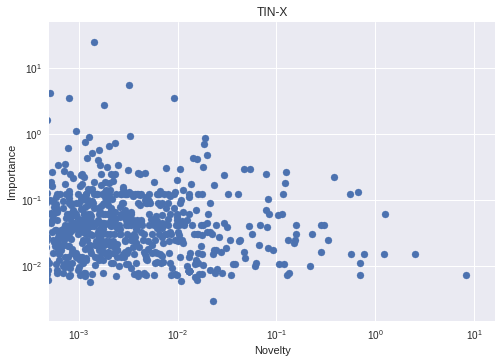

In [12]:
matplotlib.pyplot.scatter(tinx.novelty, tinx.importance)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.yscale('log')
matplotlib.pyplot.xlabel('Novelty')
matplotlib.pyplot.ylabel('Importance')
matplotlib.pyplot.title('TIN-X')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlim((max(tinx.novelty.min(),1e-3)/2,tinx.novelty.max()*2))
matplotlib.pyplot.ylim(max(tinx.importance.min()/2,1e-6), tinx.importance.max()*2)
matplotlib.pyplot.show()

### Altair interactive plot
  * https://altair-viz.github.io/

In [13]:
palette = altair.Scale(domain=['Tclin', 'Tchem', 'Tbio', 'Tdark'], range=['blue', 'green', 'red', 'gray'])
click = altair.selection_multi(fields=['tdl'])
altair.Chart(tinx, title='TIN-X: %s'%disease_name).transform_calculate(
    url='http://pharos.nih.gov/idg/targets/'+altair.datum.uniprot
    ).mark_point().encode(
      x=altair.X('novelty', scale=altair.Scale(type='log', domain=(tinx.novelty.min()*2, tinx.novelty.max()))),
      y=altair.Y('importance', scale=altair.Scale(type='log', domain=(tinx.importance.min(), tinx.importance.max()))),
      color=altair.condition(click,
                        'tdl:N', altair.value('lightgray'), 
                        scale=palette, legend=altair.Legend(title='TDL')),
    shape=altair.Shape('fam', legend=altair.Legend(title='Family')),
      href='url:N',
      tooltip=['id:N', 'name:N', 'fam:N', 'tdl:N', 'uniprot:N', 'url:N']
).properties(selection=click)

Chart({
  data:                                                     name uniprot          fam  \
  id                                                                              
  5433                                      Protein FAM35A  Q86V20         None   
  15473                 Solute carrier family 22 member 11  Q9NSA0  Transporter   
  15335                 Solute carrier family 22 member 12  Q96S37  Transporter   
  7276   Solute carrier family 2, facilitated glucose t...  Q9NRM0  Transporter   
  11076                        Magnesium transporter NIPA3  Q6NVV3         None   
  1838                   F-actin-uncapping protein LRRC16A  Q5VZK9         None   
  11891  2-oxoisovalerate dehydrogenase subunit alpha, ...  P12694       Enzyme   
  451           Aldehyde dehydrogenase family 16 member A1  Q8IZ83       Enzyme   
  13588               Ribose-phosphate pyrophosphokinase 2  P11908       Kinase   
  18356                          Transmembrane protein 171  Q8WVE6         None   
  19454                            Zinc finger protein 584  Q8IVC4           TF   
  13791               Ribose-phosphate pyrophosphokinase 3  P21108       Kinase   
  1071                              Alpha-protein kinase 1  Q96QP1       Kinase   
  20142                            Zinc finger protein 132  P52740           TF   
  15364                  Solute carrier family 40 member 1  Q9NP59  Transporter   
  7600      Hypoxanthine-guanine phosphoribosyltransferase  P00492       Enzyme   
  18506                                         Uromodulin  P07911         None   
  11547     Sodium-dependent phosphate transport protein 4  O00476  Transporter   
  11227    NACHT, LRR and PYD domains-containing protein 3  Q96P20         None   
  19578                           Zinc finger protein 518B  Q9C0D4         None   
  11427     Sodium-dependent phosphate transport protein 1  Q14916  Transporter   
  8659                                  Interleukin-1 beta  P01584         None   
  8046           Interleukin-1 receptor antagonist protein  P18510         None   
  10327                      Monocarboxylate transporter 9  Q7RTY1  Transporter   
  19789                            Zinc finger protein 446  Q9NWS9           TF   
  9999            Leucine-rich repeat-containing protein 3  Q9BY71         None   
  15161               Serine/threonine-protein kinase SIK1  P57059       Kinase   
  3204             C-type lectin domain family 12 member A  Q5QGZ9         None   
  8795                     cGMP-dependent protein kinase 2  Q13237       Kinase   
  5390                               Eyes absent homolog 3  Q99504         None   
  ...                                                  ...     ...          ...   
  299    HLA class I histocompatibility antigen, B-82 a...  Q29718         None   
  13     HLA class I histocompatibility antigen, B-41 a...  P30479         None   
  355    HLA class I histocompatibility antigen, B-8 al...  P30460         None   
  356    HLA class I histocompatibility antigen, B-18 a...  P30466         None   
  4372                   Death-associated protein kinase 1  P53355       Kinase   
  312                             Activin receptor type-1B  P36896       Kinase   
  11093         Glycylpeptide N-tetradecanoyltransferase 1  P30419       Enzyme   
  8237        Inositol 1,4,5-trisphosphate receptor type 1  Q14643           IC   
  8455                                         Beta-klotho  Q86Z14       Enzyme   
  7787               Gamma-interferon-inducible protein 16  Q16666         None   
  17794      Protein-glutamine gamma-glutamyltransferase 4  P49221       Enzyme   
  11309                                             Noggin  Q13253         None   
  2013                        Bone morphogenetic protein 7  P18075         None   
  1437                                            Ataxin-2  Q99700         None   
  16043           Scm-like with four MBT domains protein 1  Q9UHJ3   Epigenetic   
  

### For a selected target, fetch articles.

In [14]:
target_id = 3818
action = ["diseases", "targets", "articles", "list"]
params = { "disease_id":disease_id, "target_id":target_id, "limit":1000, "offset":0 }
response = client.action(schema, action, params=params)
articles = pandas.DataFrame(response['results'])
print("Articles: %d"%(articles.shape[0]))
articles['PubMed_URL'] = articles.id.astype('str').str.replace('^(.*)$', 'https://www.ncbi.nlm.nih.gov/pubmed/\\1')
articles.head()

Articles: 45


,id,title,journal,date,authors,abstract,PubMed_URL
0,25873399,Inpatient management of gout in a New Zealand ...,International journal of rheumatic diseases,2016-02,"Kennedy, Nicholas J NJ, Healy, Paul J PJ and H...",To review inpatient management of acute gout i...,https://www.ncbi.nlm.nih.gov/pubmed/25873399
1,23195793,ACTH as first line treatment for acute gout in...,"Joint, bone, spine : revue du rhumatisme",2013-05,"Daoussis, Dimitrios D, Antonopoulos, Ioannis I...",We aimed at assessing the efficacy and safety ...,https://www.ncbi.nlm.nih.gov/pubmed/23195793
2,21575286,Gout.,BMJ clinical evidence,2011-05-17,"and Underwood, Martin M.","Gout affects about 5% of men and 1% of women, ...",https://www.ncbi.nlm.nih.gov/pubmed/21575286
3,21222262,Melanocortin control of cell trafficking in va...,Advances in experimental medicine and biology,2010,"Patel, Hetal B HB, Leoni, Giovanna G, Melendez...",Over 20 years of research based upon applicati...,https://www.ncbi.nlm.nih.gov/pubmed/21222262
4,19463070,Gout--what are the treatment options?,Expert opinion on pharmacotherapy,2009-06,"Schlesinger, Naomi N, Dalbeth, Nicola N and Pe...",There has been an increase in the incidence an...,https://www.ncbi.nlm.nih.gov/pubmed/19463070
